# Analysis for MD15363

In [1]:
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pandas as pd
from matplotlib.lines import Line2D
from scipy.integrate import cumtrapz 

In [ ]:
DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363""/HX:FILLN=10739/")
df = pd.read_parquet(DATADIR)   
#print(df.columns.tolist())
#fbmodes = pd.read_parquet(DATADIR)

In [ ]:
ATLAS_PV = "ATLAS:BUNCH_LUMI_INST" 
CMS_PV = 'CMS:BUNCH_LUMI_INST'
BETASTAR_PV    = "HX:BETASTAR_IP1" #'HX:BETASTAR_IP1', HX:BETASTAR_IP2', 'HX:BETASTAR_IP5', 'HX:BETASTAR_IP8'
XING_PV = 'LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value'

bids = [20, 500, 1250, 1800,2874]  
#Q1-> 20,500
#Q1.5 --> 1250,1800

## ATLAS BUNCH BY BUNCH LUMINOSITY

### Not normalized

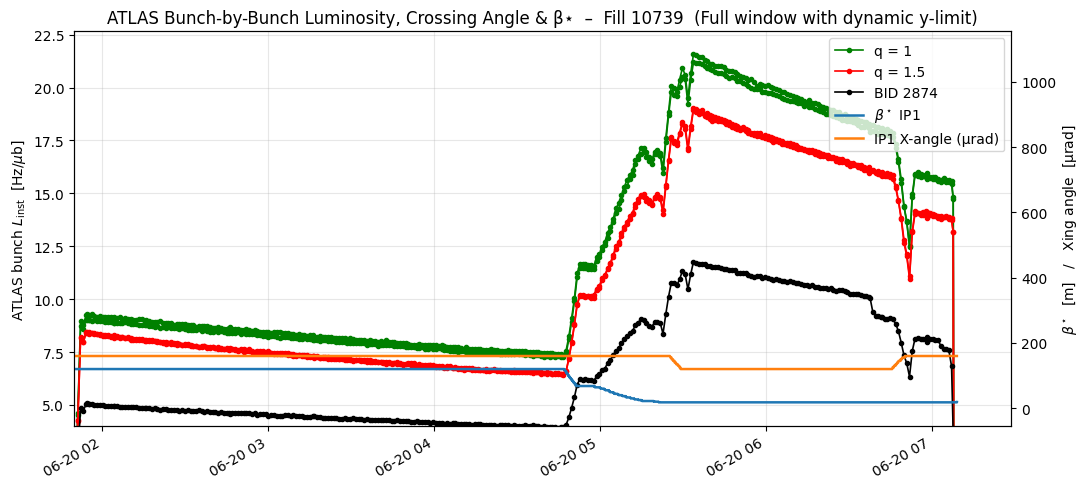

In [ ]:
BUNCH_GROUPS = {
    "q = 1"  : ([20, 500],    "green"),
    "q = 1.5": ([1250, 1800], "red"),
}
SOLO_BID = 2874  # plotted in black
dynamic_ylim = True  # Enable dynamic y-axis scaling
title_suffix = "Full window with dynamic y-limit"

# --- Load data ---
def load_bunch_array(pv_name: str, bid_list):
    raw = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)
    mat    = np.stack(raw[pv_name].values)  # nTimes × 3564
    sliced = mat[:, bid_list]
    return pd.DataFrame(
        sliced,
        index   = raw.index,
        columns = [f"B{bid}" for bid in bid_list]
    )

all_bids = [*BUNCH_GROUPS["q = 1"][0], *BUNCH_GROUPS["q = 1.5"][0], SOLO_BID]
df_atlas = load_bunch_array(ATLAS_PV, all_bids)

df_beta = (
    dd.read_parquet(DATADIR, columns=[BETASTAR_PV])
      .dropna()
      .compute()
)
df_beta.index = pd.to_datetime(df_beta.index, unit="ns")
df_beta.sort_index(inplace=True)

df_xing = (
    dd.read_parquet(DATADIR, columns=[XING_PV])
      .dropna()
      .compute()
)
df_xing.index = pd.to_datetime(df_xing.index, unit="ns")
df_xing.sort_index(inplace=True)

# --- Synchronize time range across datasets ---
t0 = max(df_atlas.index.min(), df_beta.index.min(), df_xing.index.min())
t1 = min(df_atlas.index.max(), df_beta.index.max(), df_xing.index.max())
df_atlas = df_atlas.loc[t0:t1]
df_beta  = df_beta.loc[t0:t1]
df_xing  = df_xing.loc[t0:t1]

# --- Plotting ---
fig, ax_lumi = plt.subplots(figsize=(11, 5))

# Bunch-by-bunch luminosity
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_atlas[[f"B{b}" for b in bids]].plot(
        ax=ax_lumi,
        color=colour,
        linewidth=1.2,
        marker=".",
        legend=False
    )
ax_lumi.plot(
    df_atlas.index,
    df_atlas[f"B{SOLO_BID}"],
    color="black",
    linewidth=1.2,
    marker=".",
    label="_nolegend_"
)
ax_lumi.set_ylabel(r"ATLAS bunch $L_{\rm inst}$  [Hz/$\mu$b]")

# --- Dynamic y-limit ---
if dynamic_ylim:
    y_max = df_atlas.max().max()
    ax_lumi.set_ylim(4, y_max * 1.05)  # 5% headroom
else:
    ax_lumi.set_ylim(4, 9.5)

# Title
ax_lumi.set_title(
    f"ATLAS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({title_suffix})"
)
ax_lumi.grid(alpha=0.3)

# Right axis: β⋆ and crossing angle
ax_r = ax_lumi.twinx()
df_beta[BETASTAR_PV].plot(
    ax=ax_r, color="tab:blue", linewidth=1.8, label=r"$\beta^\star$ IP1"
)
df_xing[XING_PV].plot(
    ax=ax_r, color="tab:orange", linewidth=1.8, label=r"IP1 X-angle (µrad)"
)
ax_r.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# Legend
custom_handles = [
    Line2D([0], [0], color="green", marker=".", linestyle="-", linewidth=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", linestyle="-", linewidth=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", linestyle="-", linewidth=1.2, label="BID 2874"),
    ax_r.lines[0],
    ax_r.lines[1],
]
ax_lumi.legend(handles=custom_handles, loc="upper right")

# Optional x-range zoom
ax_lumi.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()

### Split when beta star changes 

β⋆ starts changing (after 04:00) at: 2025-06-20 04:47:13.295738525


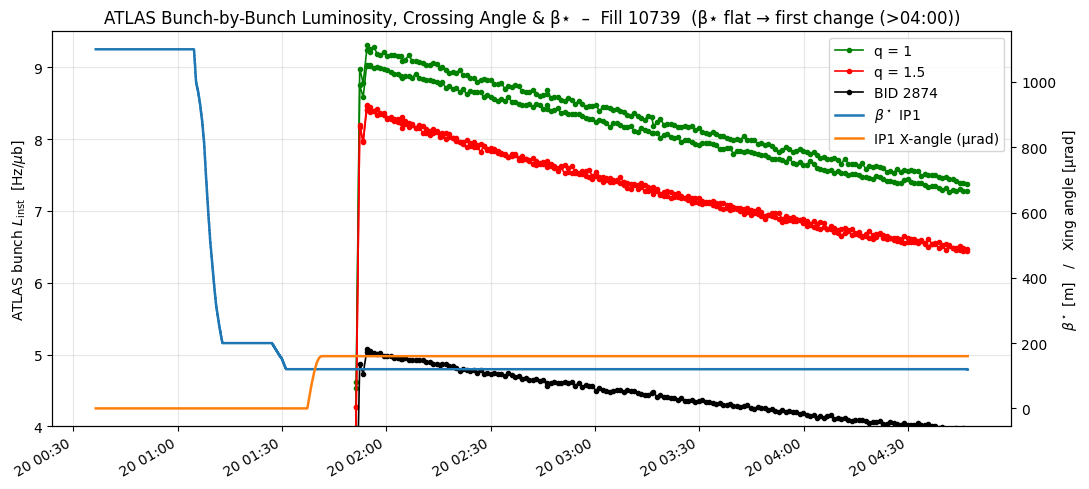

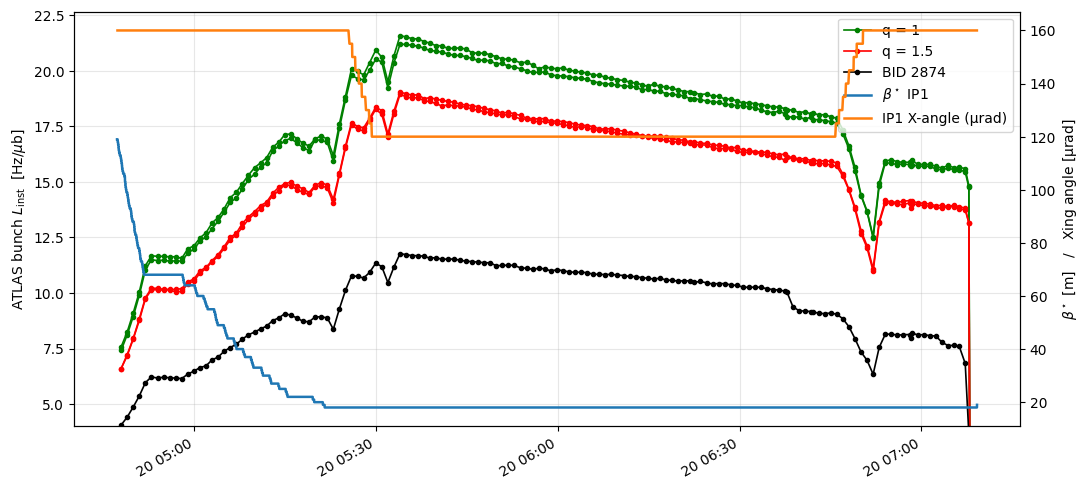

In [ ]:
# Find when β⋆ first changes *after 04:00* on that day
tol = 1e-4                                   
day0        = df_beta.index[0].floor("D")    
t_threshold = day0 + pd.Timedelta(hours=4) 
beta_series = df_beta[BETASTAR_PV]
#value that β⋆ still had *at* 04:00 (or the last tick before it)
baseline = beta_series.loc[:t_threshold].iloc[-1]    # safe even if 04:00 not in index
#first time *after* 04:00 that |β⋆−baseline| > tol
after_4h  = beta_series.loc[t_threshold:]
t_change  = after_4h[(after_4h - baseline).abs() > tol].index[0]
print("β⋆ starts changing (after 04:00) at:", t_change)


def plot_window(t_start, t_stop, title_suffix, dynamic_ylim=False):
    sl_atlas = df_atlas.loc[t_start:t_stop]
    sl_beta  = df_beta .loc[t_start:t_stop]
    sl_xing  = df_xing .loc[t_start:t_stop]

    fig, ax_lumi = plt.subplots(figsize=(11, 5))

    # left axis – all bunch curves
    for lbl, (bids, colour) in BUNCH_GROUPS.items():
        sl_atlas[[f"B{b}" for b in bids]].plot(
            ax      = ax_lumi,
            color   = colour,
            lw      = 1.2,
            marker  = ".",
            legend  = False
        )
    ax_lumi.plot(
        sl_atlas.index,
        sl_atlas[f"B{SOLO_BID}"],
        color   = "black",
        lw      = 1.2,
        marker  = ".",
        label   = "_nolegend_"
    )
    ax_lumi.set_ylabel(r"ATLAS bunch $L_{\rm inst}$  [Hz/$\mu$b]")
    if dynamic_ylim:
        y_max = sl_atlas.max().max()
        ax_lumi.set_ylim(4, y_max * 1.05)  # 5% headroom above max
    else:
        ax_lumi.set_ylim(4, 9.5)
    
        ax_lumi.set_title(
        f"ATLAS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({title_suffix})"
    )
    ax_lumi.grid(alpha=0.3)

    # ----- right axis – β⋆ and crossing angle -----
    ax_r = ax_lumi.twinx()
    sl_beta[BETASTAR_PV].plot(
        ax  = ax_r,
        color = "tab:blue",
        lw    = 1.8,
        label = r"$\beta^\star$ IP1"
    )
    sl_xing[XING_PV].plot(
        ax  = ax_r,
        color = "tab:orange",
        lw    = 1.8,
        label = r"IP1 X-angle (µrad)"
    )
    ax_r.set_ylabel(r"$\beta^\star$ [m]   /   Xing angle [µrad]")

    # ----- combined legend (bunch groups + β⋆ + crossing angle) -----
    handles = [
        Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
        Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
        Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
        ax_r.lines[0],     # β⋆
        ax_r.lines[1],     # X-angle
    ]
    ax_lumi.legend(handles=handles, loc="upper right")
    plt.tight_layout()
    return fig
#Draw the two panels: before and after β⋆ begins to change
fig_before = plot_window(df_atlas.index.min(), t_change,
                         "β⋆ flat → first change (>04:00)")
fig_after  = plot_window(t_change, df_atlas.index.max(),
                         "β⋆ changing → end",dynamic_ylim=True)

plt.show()

### Normalized by dividing by max in the beggining

### First split analysis

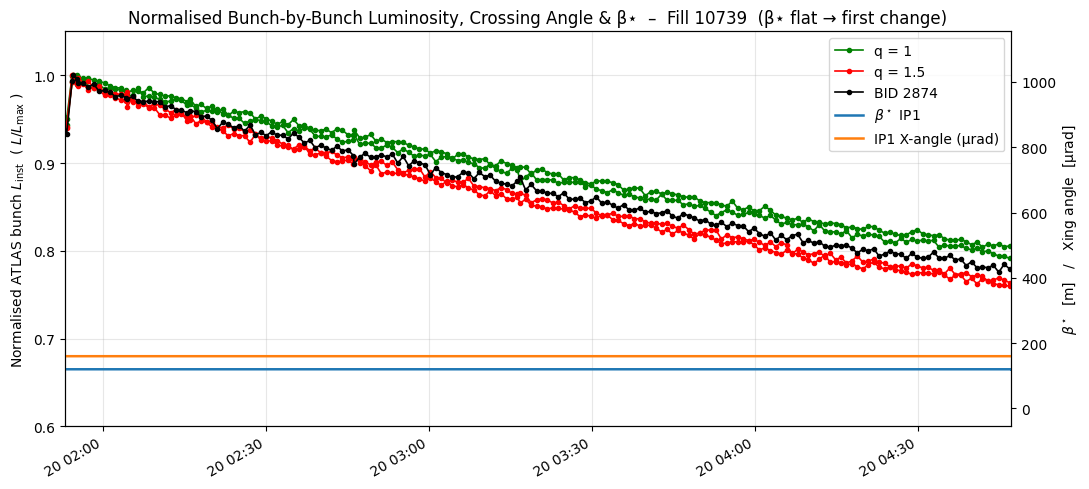

In [ ]:
# ────────────────────────────────────────────────────────────────────
# Normalised bunch-by-bunch luminosity during the *first* split
# ────────────────────────────────────────────────────────────────────

# 1) slice the data to the “before β⋆-change” period
df_first   = df_atlas.loc[df_atlas.index.min() : t_change]
beta_first = df_beta .loc[df_beta .index.min() : t_change]
xing_first = df_xing .loc[df_xing .index.min() : t_change]

# 2) per-bunch maxima in that window
max_vals = df_first.max()        # one value per column “B###”

# 3) normalise every bunch curve by its own maximum
df_norm = df_first.div(max_vals)

# 4) plot – same style as the original panel
fig_norm, ax_lum = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_norm[[f"B{b}" for b in bids]].plot(
        ax     = ax_lum,
        color  = colour,
        lw     = 1.2,
        marker = ".",
        legend = False
    )

# solo bunch 2874
ax_lum.plot(
    df_norm.index,
    df_norm[f"B{SOLO_BID}"],
    color  = "black",
    lw     = 1.2,
    marker = ".",
    label  = "_nolegend_"
)

ax_lum.set_ylabel("Normalised ATLAS bunch $L_{\\rm inst}$  ( $L/L_{\\max}$ )")
ax_lum.set_ylim(0.6, 1.05)
ax_lum.set_title(
    "Normalised Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  (β⋆ flat → first change)"
)
ax_lum.grid(alpha=0.3)

# right axis – β⋆ and crossing angle (unchanged, absolute units)
ax_r = ax_lum.twinx()
beta_first[BETASTAR_PV].plot(
    ax   = ax_r,
    color= "tab:blue",
    lw   = 1.8,
    label= r"$\beta^\star$ IP1"
)
xing_first[XING_PV].plot(
    ax   = ax_r,
    color= "tab:orange",
    lw   = 1.8,
    label= r"IP1 X-angle (µrad)"
)
ax_r.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# combined legend
handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],          # β⋆
    ax_r.lines[1],          # crossing angle
]
start_time = df_first.index[0].replace(hour=1, minute=53, second=0)

# Set x-axis limits
ax_lum.set_xlim([start_time, t_change])
ax_lum.legend(handles=handles, loc="upper right")
plt.tight_layout()
plt.show()


#### Raw Integrated Luminosity

/tmp/ipykernel_41495/377169031.py:6: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cum_abs[col] = cumtrapz(df_first[col].values, t_sec_first, initial=0.0)


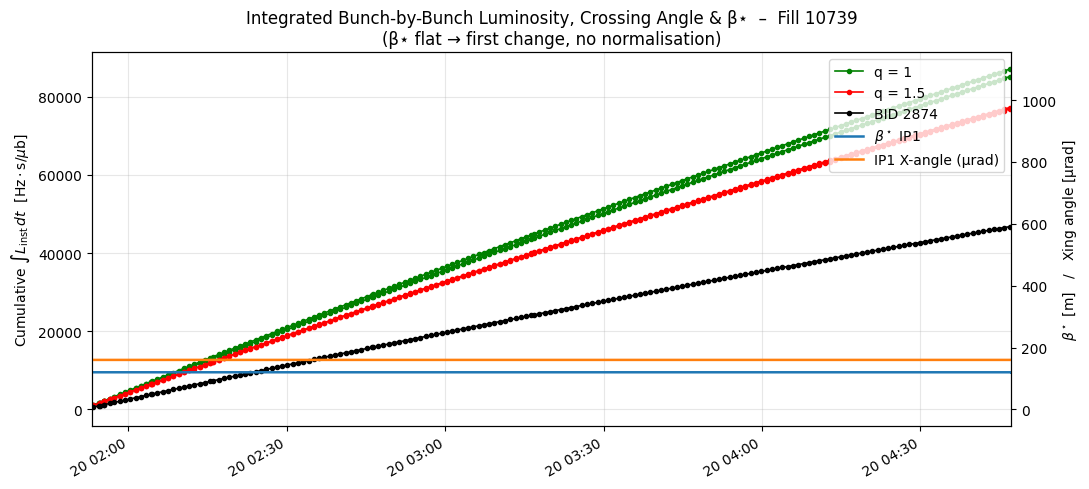

In [ ]:
# 1) cumulative ∫L_inst dt for each bunch
t_sec_first = (df_first.index - df_first.index[0]).total_seconds()

cum_abs = {}
for col in df_first.columns:
    cum_abs[col] = cumtrapz(df_first[col].values, t_sec_first, initial=0.0)

df_cum = pd.DataFrame(cum_abs, index=df_first.index)

# 2) plot
fig_int, ax_lum = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum[[f"B{b}" for b in bids]].plot(
        ax=ax_lum, color=colour, lw=1.2, marker=".", legend=False
    )

# solo bunch 2874
ax_lum.plot(
    df_cum.index, df_cum[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_lum.set_ylabel(r"Cumulative $\int L_{\rm inst}\,dt$  [$\mathrm{Hz\cdot s}/\mu$b]")
ax_lum.set_title(
    "Integrated Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739\n"
    "(β⋆ flat → first change, no normalisation)"
)
ax_lum.grid(alpha=0.3)

# right axis – β⋆ and crossing angle (absolute units, unchanged)
ax_r = ax_lum.twinx()
beta_first[BETASTAR_PV].plot(
    ax=ax_r, color="tab:blue", lw=1.8, label=r"$\beta^\star$ IP1"
)
xing_first[XING_PV].plot(
    ax=ax_r, color="tab:orange", lw=1.8, label=r"IP1 X-angle (µrad)"
)
ax_r.set_ylabel(r"$\beta^\star$ [m]   /   Xing angle [µrad]")

# combined legend
handles_int = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],                   # β⋆
    ax_r.lines[1],                   # crossing angle
]
ax_lum.legend(handles=handles_int, loc="upper right")

ax_lum.set_xlim([start_time, t_change])
plt.tight_layout()
plt.show()

In [ ]:
final_values = df_cum.iloc[-1]          # last row of the cumulative DataFrame
print("Cumulative luminosity delivered up to β⋆ change:")
print(final_values.to_string(float_format="%.3e"))

Cumulative luminosity delivered up to β⋆ change:
B20     8.518e+04
B500    8.708e+04
B1250   7.726e+04
B1800   7.685e+04
B2874   4.677e+04


In [ ]:
def pct_diff(a, b):
    return abs(a - b) / ((abs(a) + abs(b)) / 2) * 100

final_vals = df_cum.iloc[-1]            

# B20 vs B500  (q = 1)
L20   = final_vals["B20"]
L500  = final_vals["B500"]
pdiff_20_500 = pct_diff(L20, L500)

# B1250 vs B1800  (q = 1.5)
L1250 = final_vals["B1250"]
L1800 = final_vals["B1800"]
pdiff_1250_1800 = pct_diff(L1250, L1800)

print("Final cumulative luminosity (Hz·s / μb) at β⋆ change:")
print(f"  B20   : {L20 : .3e}")
print(f"  B500  : {L500: .3e}   →  % diff: {pdiff_20_500:.2f} %\n")
print(f"  B1250 : {L1250: .3e}")
print(f"  B1800 : {L1800: .3e}   →  % diff: {pdiff_1250_1800:.2f} %")


Final cumulative luminosity (Hz·s / μb) at β⋆ change:
  B20   :  8.518e+04
  B500  :  8.708e+04   →  % diff: 2.21 %

  B1250 :  7.726e+04
  B1800 :  7.685e+04   →  % diff: 0.53 %


In [ ]:
def pct_diff(a, b):
    return abs(a - b) / ((abs(a) + abs(b)) / 2) * 100

mean_q1   = final_vals[["B20", "B500"]].mean()      # q = 1
mean_q15  = final_vals[["B1250", "B1800"]].mean()   # q = 1.5
pdiff_means = pct_diff(mean_q1, mean_q15)

print("Mean cumulative luminosity up to β⋆ change:")
print(f"  q = 1   mean (B20 & B500) : {mean_q1 : .3e}  Hz·s/μb")
print(f"  q = 1.5 mean (B1250 & B1800): {mean_q15: .3e}  Hz·s/μb")
print(f"\nPercent difference (means, q = 1  vs  q = 1.5): {pdiff_means:.2f} %")


Mean cumulative luminosity up to β⋆ change:
  q = 1   mean (B20 & B500) :  8.613e+04  Hz·s/μb
  q = 1.5 mean (B1250 & B1800):  7.706e+04  Hz·s/μb

Percent difference (means, q = 1  vs  q = 1.5): 11.12 %


#### Normalized to peak Integrated Luminosity
“If this bunch had run at exactly its first-window peak luminosity, how many seconds of that ideal beam time would deliver the same integrated luminosity it actually delivered up to each moment?”

/tmp/ipykernel_41495/1837660650.py:12: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm[col].values, t_sec, initial=0.0)


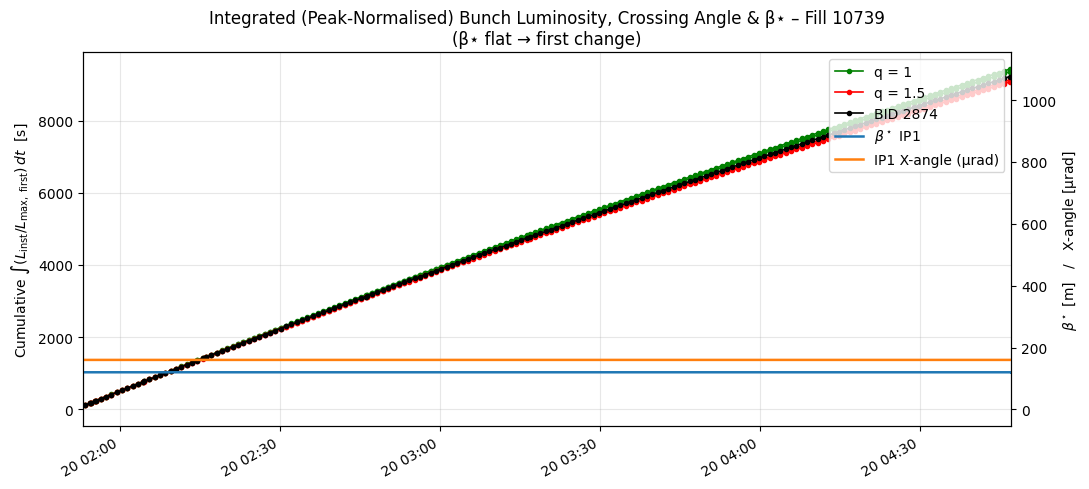

In [ ]:
# A)  prepare the first-window data (β⋆ still flat)
df_first   = df_atlas.loc[df_atlas.index.min() : t_change]
beta_first = df_beta  .loc[df_beta.index.min() : t_change]
xing_first = df_xing  .loc[df_xing.index.min() : t_change]
# B)  normalise every bunch by its own maximum in that window
max_vals_first = df_first.max()          # Series: one value per column
df_norm = df_first.div(max_vals_first)   # values now 0-to-1
# C)  cumulative integral of the normalised curves
#     (units -> seconds, since y is dimensionless)
t_sec = (df_norm.index - df_norm.index[0]).total_seconds()
df_cum_norm = pd.DataFrame(
    {col: cumtrapz(df_norm[col].values, t_sec, initial=0.0)
     for col in df_norm.columns},
    index=df_norm.index
)
# D)  plot
fig, ax_l = plt.subplots(figsize=(11, 5))

# left axis – cumulative ∫(L / L_peak) dt
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum_norm[[f"B{b}" for b in bids]].plot(
        ax=ax_l, color=colour, lw=1.2, marker=".", legend=False
    )
# solo bunch 2874
ax_l.plot(
    df_cum_norm.index, df_cum_norm[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_l.set_ylabel(r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]")
ax_l.set_title(
    "Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(β⋆ flat → first change)"
)
ax_l.grid(alpha=0.3)

# right axis – β⋆ and crossing angle (unchanged)
ax_r = ax_l.twinx()
beta_first[BETASTAR_PV].plot(ax=ax_r, color="tab:blue",   lw=1.8, label=r"$\beta^\star$ IP1")
xing_first[XING_PV]    .plot(ax=ax_r, color="tab:orange", lw=1.8, label=r"IP1 X-angle (µrad)")
ax_r.set_ylabel(r"$\beta^\star$ [m]   /   X-angle [µrad]")

# legend – combine bunch groups + β⋆ + X-angle
handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],    # β⋆
    ax_r.lines[1],    # crossing angle
]
ax_l.legend(handles=handles, loc="upper right")

# (optional) set the same x-range you used before
start_time = df_first.index[0].replace(hour=1, minute=53, second=0)
ax_l.set_xlim([start_time, t_change])

plt.tight_layout()
plt.show()


#### Statistics

In [ ]:
final_values_norm = df_cum_norm.iloc[-1]

print("Peak-normalised cumulative luminosity delivered up to β⋆ change:")
print(final_values_norm.to_string(float_format="%.3e"))

Peak-normalised cumulative luminosity delivered up to β⋆ change:
B20     9.425e+03
B500    9.354e+03
B1250   9.126e+03
B1800   9.070e+03
B2874   9.219e+03


In [ ]:
def rel_pct_diff(a, b):
    """Relative percentage difference w.r.t. the first value (a)."""
    return abs(a - b) / abs(a) * 100          # reference = a

def sym_pct_diff(a, b):
    """Symmetric percentage difference (reference-free)."""
    return abs(a - b) / ((abs(a) + abs(b)) / 2) * 100   # reference = mean

final_vals_norm = df_cum_norm.iloc[-1]       # units: seconds

# pair 1  (q = 1)
L20,  L500  = final_vals_norm["B20"],  final_vals_norm["B500"]
rel_20_500  = rel_pct_diff(L20, L500)
sym_20_500  = sym_pct_diff(L20, L500)

# pair 2  (q = 1.5)
L1250, L1800 = final_vals_norm["B1250"], final_vals_norm["B1800"]
rel_1250_1800 = rel_pct_diff(L1250, L1800)
sym_1250_1800 = sym_pct_diff(L1250, L1800)

print("Peak-normalised cumulative luminosity up to β⋆ change (seconds):\n")

print(f"  B20   : {L20 : .3e} s")
print(f"  B500  : {L500: .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500 :6.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500 :6.4f} %\n")

print(f"  B1250 : {L1250: .3e} s")
print(f"  B1800 : {L1800: .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800 :6.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800 :6.4f} %")


Peak-normalised cumulative luminosity up to β⋆ change (seconds):

  B20   :  9.425e+03 s
  B500  :  9.354e+03 s
    →  relative % diff (ref B20):   0.7606 %
    →  symmetric % diff:            0.7635 %

  B1250 :  9.126e+03 s
  B1800 :  9.070e+03 s
    →  relative % diff (ref B1250): 0.6057 %
    →  symmetric % diff:            0.6075 %


In [ ]:
# last row = total (peak-normalised) integrated luminosity (seconds)
final_vals_norm = df_cum_norm.iloc[-1]

group_q1  = ["B20", "B500"]
group_q15 = ["B1250", "B1800"]

tot_q1  = final_vals_norm[group_q1 ].sum()   # or .mean()
tot_q15 = final_vals_norm[group_q15].sum()

sym_pct = sym_pct_diff(tot_q1, tot_q15)
rel_pct = rel_pct_diff(tot_q1, tot_q15)      # now stored in rel_pct

print("Peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 total (B20 + B500):   {tot_q1 : .3e}  s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15: .3e}  s")
print(f"  Symmetric % difference: {sym_pct:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_pct:.3f} %")


Peak-normalised cumulative luminosity at β⋆ change:
  q = 1 total (B20 + B500):    1.878e+04  s
  q = 1.5 total (B1250 + B1800):  1.820e+04  s
  Symmetric % difference: 3.153 %
  Relative  % difference (ref q=1): 3.104 %


In [ ]:
# last row = total (peak-normalised) integrated luminosity (seconds)
final_vals_norm = df_cum_norm.iloc[-1]

group_q1  = ["B20", "B500"]
group_q15 = ["B1250", "B1800"]

tot_q1  = final_vals_norm[group_q1 ].mean()   # or .mean()
tot_q15 = final_vals_norm[group_q15].mean()

sym_pct = sym_pct_diff(tot_q1, tot_q15)
rel_pct = rel_pct_diff(tot_q1, tot_q15)      # now stored in rel_pct

print("Peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 total (B20 + B500):   {tot_q1 : .3e}  s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15: .3e}  s")
print(f"  Symmetric % difference: {sym_pct:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_pct:.3f} %")

Peak-normalised cumulative luminosity at β⋆ change:
  q = 1 total (B20 + B500):    9.389e+03  s
  q = 1.5 total (B1250 + B1800):  9.098e+03  s
  Symmetric % difference: 3.153 %
  Relative  % difference (ref q=1): 3.104 %


### Second split analysis

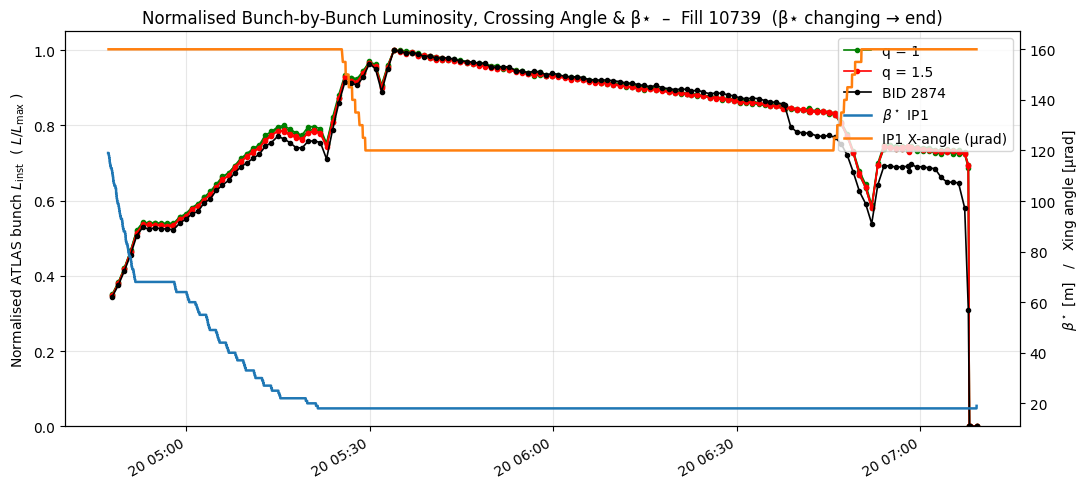

In [ ]:
# 1) slice the data to the “after β⋆-change” period
df_second   = df_atlas.loc[t_change : df_atlas.index.max()]
beta_second = df_beta .loc[t_change : df_beta .index.max()]
xing_second = df_xing .loc[t_change : df_xing .index.max()]

# 2) per-bunch maxima in that window
max_vals_2 = df_second.max()          # one value per column “B###”

# 3) normalise every bunch curve by its own maximum
df_norm_2 = df_second.div(max_vals_2)

# 4) plot – same style as before
fig_norm2, ax_lum2 = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_norm_2[[f"B{b}" for b in bids]].plot(
        ax     = ax_lum2,
        color  = colour,
        lw     = 1.2,
        marker = ".",
        legend = False
    )

# solo bunch 2874
ax_lum2.plot(
    df_norm_2.index,
    df_norm_2[f"B{SOLO_BID}"],
    color  = "black",
    lw     = 1.2,
    marker = ".",
    label  = "_nolegend_"
)

ax_lum2.set_ylabel("Normalised ATLAS bunch $L_{\\rm inst}$  ( $L/L_{\\max}$ )")
ax_lum2.set_ylim(0, 1.05)
ax_lum2.set_title(
    "Normalised Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  (β⋆ changing → end)"
)
ax_lum2.grid(alpha=0.3)

# right axis – β⋆ and crossing angle (absolute units, unchanged)
ax_r2 = ax_lum2.twinx()
beta_second[BETASTAR_PV].plot(
    ax   = ax_r2,
    color= "tab:blue",
    lw   = 1.8,
    label= r"$\beta^\star$ IP1"
)
xing_second[XING_PV].plot(
    ax   = ax_r2,
    color= "tab:orange",
    lw   = 1.8,
    label= r"IP1 X-angle (µrad)"
)
ax_r2.set_ylabel(r"$\beta^\star$ [m]   /   Xing angle [µrad]")

# combined legend
handles2 = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r2.lines[0],          # β⋆
    ax_r2.lines[1],          # crossing angle
]
ax_lum2.legend(handles=handles2, loc="upper right")

plt.tight_layout()
plt.show()


#### Integrated Luminosity

/tmp/ipykernel_41495/2275737703.py:16: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm_2[col].values, t_sec_2, initial=0.0)


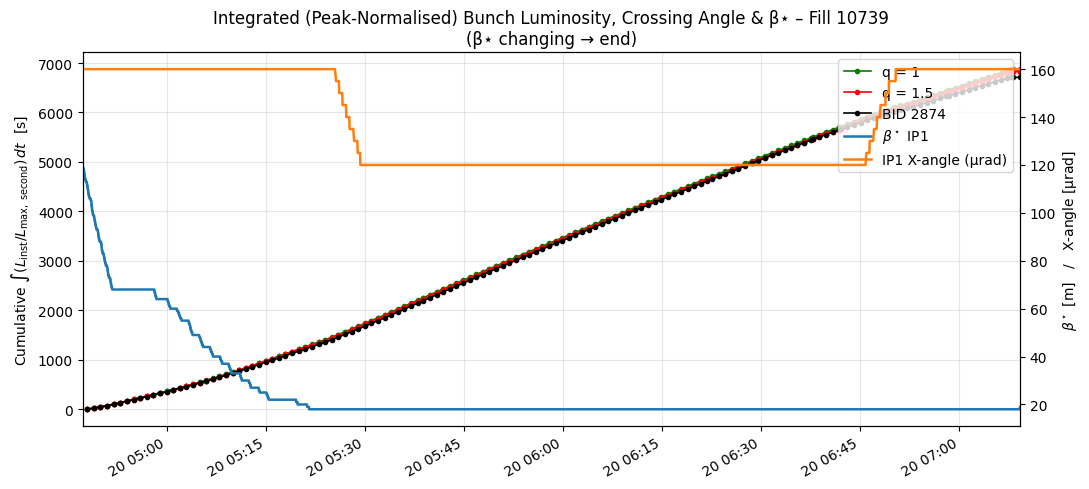

In [ ]:
df_second   = df_atlas.loc[t_change : df_atlas.index.max()]
beta_second = df_beta  .loc[t_change : df_beta .index.max()]
xing_second = df_xing  .loc[t_change : df_xing .index.max()]

# ----------------------------------------------------------------
# B)  normalise each bunch by its own maximum in THIS window
# ----------------------------------------------------------------
max_vals_second = df_second.max()              # Series per column
df_norm_2 = df_second.div(max_vals_second)     # values 0-to-1

# ----------------------------------------------------------------
# C)  cumulative integral of the normalised curves
# ----------------------------------------------------------------
t_sec_2 = (df_norm_2.index - df_norm_2.index[0]).total_seconds()
df_cum_norm_2 = pd.DataFrame(
    {col: cumtrapz(df_norm_2[col].values, t_sec_2, initial=0.0)
     for col in df_norm_2.columns},
    index=df_norm_2.index
)

# ----------------------------------------------------------------
# D)  plot
# ----------------------------------------------------------------
fig2, ax_l2 = plt.subplots(figsize=(11, 5))

# left axis – cumulative ∫(L / L_peak-second) dt
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum_norm_2[[f"B{b}" for b in bids]].plot(
        ax=ax_l2, color=colour, lw=1.2, marker=".", legend=False
    )

# solo bunch 2874
ax_l2.plot(
    df_cum_norm_2.index, df_cum_norm_2[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_l2.set_ylabel(
    r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm second}})\,dt$  [s]"
)
ax_l2.set_title(
    "Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(β⋆ changing → end)"
)
ax_l2.grid(alpha=0.3)

# right axis – β⋆ and crossing angle during second window
ax_r2 = ax_l2.twinx()
beta_second[BETASTAR_PV].plot(
    ax=ax_r2, color="tab:blue", lw=1.8, label=r"$\beta^\star$ IP1"
)
xing_second[XING_PV].plot(
    ax=ax_r2, color="tab:orange", lw=1.8, label=r"IP1 X-angle (µrad)"
)
ax_r2.set_ylabel(r"$\beta^\star$ [m]   /   X-angle [µrad]")

# legend  (two bunch groups + solo + β⋆ + X-angle)
handles2 = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r2.lines[0],     # β⋆
    ax_r2.lines[1],     # crossing angle
]
ax_l2.legend(handles=handles2, loc="upper right")

# optional: zoom from t_change to end (already the slice)
ax_l2.set_xlim([t_change, df_second.index.max()])

plt.tight_layout()
plt.show()

#### Statistics

In [ ]:
final_values_norm_2 = df_cum_norm_2.iloc[-1]

print("Peak-normalised cumulative luminosity delivered up to β⋆ change:")
print(final_values_norm_2.to_string(float_format="%.3e"))

Peak-normalised cumulative luminosity delivered up to β⋆ change:
B20     6.876e+03
B500    6.840e+03
B1250   6.839e+03
B1800   6.827e+03
B2874   6.711e+03


In [ ]:
def rel_pct_diff_2(a, b):
    """Relative percentage difference w.r.t. the first value (a)."""
    return abs(a - b) / abs(a) * 100          # reference = a

def sym_pct_diff_2(a, b):
    """Symmetric percentage difference (reference-free)."""
    return abs(a - b) / ((abs(a) + abs(b)) / 2) * 100
final_vals_norm_2 = df_cum_norm_2.iloc[-1]    
# pair 1  (q = 1)
L20_2,  L500_2  = final_vals_norm_2["B20"],  final_vals_norm_2["B500"]
rel_20_500_2    = rel_pct_diff_2(L20_2, L500_2)
sym_20_500_2    = sym_pct_diff_2(L20_2, L500_2)

# pair 2  (q = 1.5)
L1250_2, L1800_2 = final_vals_norm_2["B1250"], final_vals_norm_2["B1800"]
rel_1250_1800_2  = rel_pct_diff_2(L1250_2, L1800_2)
sym_1250_1800_2  = sym_pct_diff_2(L1250_2, L1800_2)

print("Peak-normalised cumulative luminosity up to β⋆ change (seconds):\n")

print(f"  B20   : {L20_2  : .3e} s")
print(f"  B500  : {L500_2 : .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500_2  :8.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500_2  :8.4f} %\n")

print(f"  B1250 : {L1250_2: .3e} s")
print(f"  B1800 : {L1800_2: .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800_2 :8.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800_2 :8.4f} %")

Peak-normalised cumulative luminosity up to β⋆ change (seconds):

  B20   :  6.876e+03 s
  B500  :  6.840e+03 s
    →  relative % diff (ref B20):     0.5324 %
    →  symmetric % diff:              0.5338 %

  B1250 :  6.839e+03 s
  B1800 :  6.827e+03 s
    →  relative % diff (ref B1250):   0.1837 %
    →  symmetric % diff:              0.1839 %


In [ ]:
mean_q1_2  = final_vals_norm_2[["B20", "B500"]].mean()       # q = 1
mean_q15_2 = final_vals_norm_2[["B1250", "B1800"]].mean()    # q = 1.5

# percentage differences
rel_mean_2 = rel_pct_diff_2(mean_q1_2,  mean_q15_2)          # ref = q1 mean
sym_mean_2 = sym_pct_diff_2(mean_q1_2, mean_q15_2)           # symmetric
print("Mean peak-normalised cumulative luminosity up to β⋆ change (seconds):\n")

print(f"  q = 1   mean (B20 & B500)   : {mean_q1_2  : .3e}  s")
print(f"  q = 1.5 mean (B1250 & B1800): {mean_q15_2 : .3e}  s")

print(f"\n  Relative  % diff (ref q = 1 mean): {rel_mean_2:8.4f} %")
print(f"  Symmetric % diff:                  {sym_mean_2:8.4f} %")

Mean peak-normalised cumulative luminosity up to β⋆ change (seconds):

  q = 1   mean (B20 & B500)   :  6.858e+03  s
  q = 1.5 mean (B1250 & B1800):  6.833e+03  s

  Relative  % diff (ref q = 1 mean):   0.3618 %
  Symmetric % diff:                    0.3624 %


In [ ]:
group_q1_2   = ["B20", "B500"]        # q = 1
group_q15_2  = ["B1250", "B1800"]     # q = 1.5
tot_q1_2  = final_vals_norm_2[group_q1_2 ].sum()
tot_q15_2 = final_vals_norm_2[group_q15_2].sum()
rel_tot_2 = rel_pct_diff_2(tot_q1_2,  tot_q15_2)   # reference = q1 total
sym_tot_2 = sym_pct_diff_2(tot_q1_2, tot_q15_2)    # symmetric
print("Peak-normalised cumulative luminosity at β⋆ change (seconds):\n")

print(f"  q = 1   total (B20 + B500)   : {tot_q1_2  : .3e}  s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15_2 : .3e}  s")

print(f"\n  Relative  % diff (ref q = 1 total): {rel_tot_2:8.4f} %")
print(f"  Symmetric % diff:                    {sym_tot_2:8.4f} %")


Peak-normalised cumulative luminosity at β⋆ change (seconds):

  q = 1   total (B20 + B500)   :  1.372e+04  s
  q = 1.5 total (B1250 + B1800):  1.367e+04  s

  Relative  % diff (ref q = 1 total):   0.3618 %
  Symmetric % diff:                      0.3624 %


### Overall

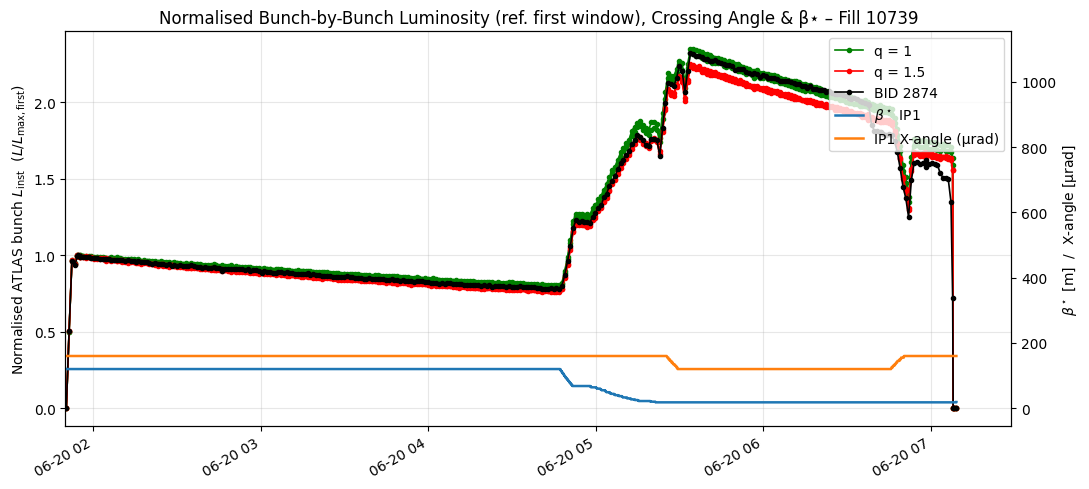

In [ ]:

# Normalise the whole fill to the *first-window* peak of each bunch

# 1) reference maxima from the first split (β⋆ flat → t_change)
max_first = df_atlas.loc[t0:t_change].max()

# 2) normalise the *entire* df_atlas by those maxima
df_norm_all = df_atlas.div(max_first)

# 3) plot – same layout as your original figure
pad  = 0.05                                         # 5 % head- & foot-room
ymin = df_norm_all.min().min()
ymax = df_norm_all.max().max()
yrange = ymax - ymin
ylow  = ymin - pad * yrange
yhigh = ymax + pad * yrange

fig, ax_l = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_norm_all[[f"B{b}" for b in bids]].plot(
        ax=ax_l, color=colour, lw=1.2, marker=".", legend=False
    )

ax_l.plot(
    df_norm_all.index, df_norm_all[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_l.set_ylabel(
    r"Normalised ATLAS bunch $L_{\rm inst}$  ($L/L_{\max,\mathrm{first}}$)"
)
ax_l.set_ylim(ylow, yhigh)                          # ⬅ dynamic limits
ax_l.set_title(
    "Normalised Bunch-by-Bunch Luminosity (ref. first window), "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l.grid(alpha=0.3)

# right-axis traces stay the same
ax_r = ax_l.twinx()
df_beta[BETASTAR_PV].plot(ax=ax_r, color="tab:blue",   lw=1.8, label=r"$\beta^\star$ IP1")
df_xing[XING_PV]   .plot(ax=ax_r, color="tab:orange", lw=1.8, label=r"IP1 X-angle (µrad)")
ax_r.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0], ax_r.lines[1],
]
ax_l.legend(handles=handles, loc="upper right")
ax_l.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()

#### Integrated luminosity

/tmp/ipykernel_41495/201256981.py:4: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm_all[col].values, t_sec_all, initial=0.0)


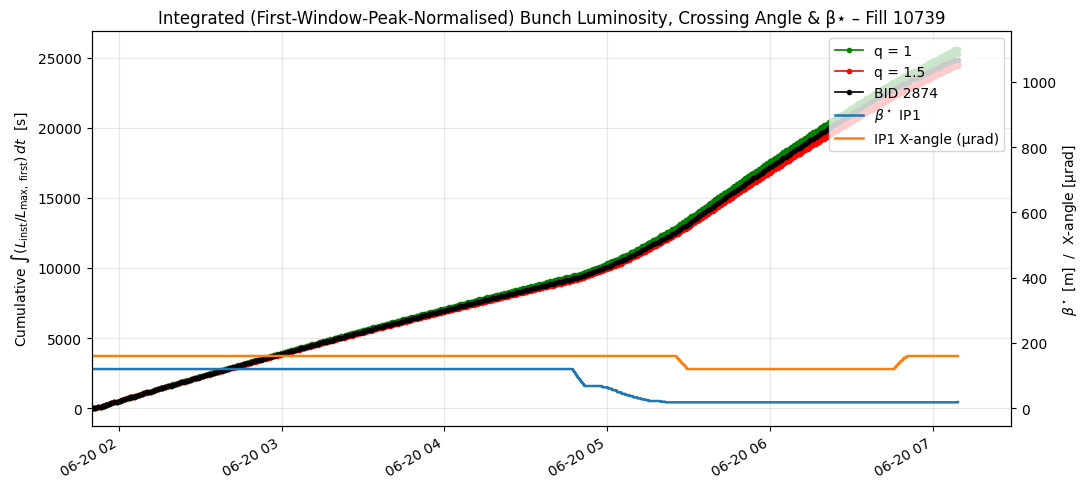

In [ ]:
# 1) cumulative integral for each bunch
t_sec_all = (df_norm_all.index - df_norm_all.index[0]).total_seconds()
df_cum_all = pd.DataFrame(
    {col: cumtrapz(df_norm_all[col].values, t_sec_all, initial=0.0)
     for col in df_norm_all.columns},
    index=df_norm_all.index
)

# 2) dynamic y-range (±5 % padding)
pad = 0.05
ymin, ymax = df_cum_all.min().min(), df_cum_all.max().max()
yrange     = ymax - ymin
ylow, yhigh = ymin - pad*yrange, ymax + pad*yrange

# 3) plot
fig_int, ax_l = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum_all[[f"B{b}" for b in bids]].plot(
        ax=ax_l, color=colour, lw=1.2, marker=".", legend=False
    )

# solo bunch
ax_l.plot(df_cum_all.index, df_cum_all[f"B{SOLO_BID}"],
          color="black", lw=1.2, marker=".", label="_nolegend_")

ax_l.set_ylabel(r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]")
ax_l.set_ylim(ylow, yhigh)
ax_l.set_title(
    "Integrated (First-Window-Peak-Normalised) Bunch Luminosity, "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l.grid(alpha=0.3)

# right axis – β⋆ & crossing angle
ax_r = ax_l.twinx()
df_beta[BETASTAR_PV].plot(ax=ax_r, color="tab:blue",   lw=1.8, label=r"$\beta^\star$ IP1")
df_xing[XING_PV]   .plot(ax=ax_r, color="tab:orange", lw=1.8, label=r"IP1 X-angle (µrad)")
ax_r.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

# combined legend
handles = [
    Line2D([0],[0],color="green",marker=".",lw=1.2,label="q = 1"),
    Line2D([0],[0],color="red",  marker=".",lw=1.2,label="q = 1.5"),
    Line2D([0],[0],color="black",marker=".",lw=1.2,label=f"BID {SOLO_BID}"),
    ax_r.lines[0], ax_r.lines[1],
]
ax_l.legend(handles=handles, loc="upper right")
ax_l.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()

#### Statistics

In [ ]:
final_values_norm_all = df_cum_all.iloc[-1]   # units: seconds

print("Peak-normalised cumulative luminosity delivered over the whole fill:")
print(final_values_norm_all.to_string(float_format="%.3e"))

Peak-normalised cumulative luminosity delivered over the whole fill:
B20     2.560e+04
B500    2.526e+04
B1250   2.455e+04
B1800   2.437e+04
B2874   2.483e+04


In [ ]:
def rel_pct_diff_all(a, b):
    """Relative percentage difference w.r.t. the first value (a)."""
    return abs(a - b) / abs(a) * 100

def sym_pct_diff_all(a, b):
    """Symmetric percentage difference (reference-free)."""
    return abs(a - b) / ((abs(a) + abs(b)) / 2) * 100
final_vals_norm_all = df_cum_all.iloc[-1] 
# pair 1  (q = 1)
L20_all,  L500_all   = final_vals_norm_all["B20"],  final_vals_norm_all["B500"]
rel_20_500_all       = rel_pct_diff_all(L20_all, L500_all)
sym_20_500_all       = sym_pct_diff_all(L20_all, L500_all)
# pair 2  (q = 1.5)
L1250_all, L1800_all = final_vals_norm_all["B1250"], final_vals_norm_all["B1800"]
rel_1250_1800_all    = rel_pct_diff_all(L1250_all, L1800_all)
sym_1250_1800_all    = sym_pct_diff_all(L1250_all, L1800_all)

print("Peak-normalised cumulative luminosity over the whole fill (seconds):\n")
print(f"  B20   : {L20_all   : .3e} s")
print(f"  B500  : {L500_all  : .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500_all :8.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500_all :8.4f} %\n")

print(f"  B1250 : {L1250_all : .3e} s")
print(f"  B1800 : {L1800_all : .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800_all :8.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800_all :8.4f} %")


Peak-normalised cumulative luminosity over the whole fill (seconds):

  B20   :  2.560e+04 s
  B500  :  2.526e+04 s
    →  relative % diff (ref B20):     1.3429 %
    →  symmetric % diff:              1.3519 %

  B1250 :  2.455e+04 s
  B1800 :  2.437e+04 s
    →  relative % diff (ref B1250):   0.6958 %
    →  symmetric % diff:              0.6982 %


In [ ]:
# means of the two bunches in each q-group
mean_q1_all   = final_vals_norm_all[["B20", "B500"]].mean()      # q = 1
mean_q15_all  = final_vals_norm_all[["B1250", "B1800"]].mean()   # q = 1.5

# percentage differences
rel_mean_all  = rel_pct_diff_all(mean_q1_all,  mean_q15_all)     # ref = q1 mean
sym_mean_all  = sym_pct_diff_all(mean_q1_all, mean_q15_all)      # symmetric
print("Mean peak-normalised cumulative luminosity over the whole fill (seconds):\n")

print(f"  q = 1   mean (B20 & B500)   : {mean_q1_all  : .3e}  s")
print(f"  q = 1.5 mean (B1250 & B1800): {mean_q15_all : .3e}  s")

print(f"\n  Relative  % diff (ref q = 1 mean): {rel_mean_all:8.4f} %")
print(f"  Symmetric % diff:                  {sym_mean_all:8.4f} %")

Mean peak-normalised cumulative luminosity over the whole fill (seconds):

  q = 1   mean (B20 & B500)   :  2.543e+04  s
  q = 1.5 mean (B1250 & B1800):  2.446e+04  s

  Relative  % diff (ref q = 1 mean):   3.8045 %
  Symmetric % diff:                    3.8783 %


In [ ]:
group_q1_all   = ["B20", "B500"]        # q = 1
group_q15_all  = ["B1250", "B1800"]     # q = 1.5

tot_q1_all  = final_vals_norm_all[group_q1_all ].sum()
tot_q15_all = final_vals_norm_all[group_q15_all].sum()
rel_tot_all = rel_pct_diff_all(tot_q1_all,  tot_q15_all)   # reference = q1 total
sym_tot_all = sym_pct_diff_all(tot_q1_all, tot_q15_all)    # symmetric

print("Peak-normalised cumulative luminosity over the whole fill (seconds):\n")
print(f"  q = 1   total (B20 + B500)   : {tot_q1_all  : .3e}  s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15_all : .3e}  s")
print(f"\n  Relative  % diff (ref q = 1 total): {rel_tot_all:8.4f} %")
print(f"  Symmetric % diff:                    {sym_tot_all:8.4f} %")

Peak-normalised cumulative luminosity over the whole fill (seconds):

  q = 1   total (B20 + B500)   :  5.085e+04  s
  q = 1.5 total (B1250 + B1800):  4.892e+04  s

  Relative  % diff (ref q = 1 total):   3.8045 %
  Symmetric % diff:                      3.8783 %


## CMS Luminosity

In [ ]:
CMS_PV = 'CMS:BUNCH_LUMI_INST'

### Not Normalized, Full window

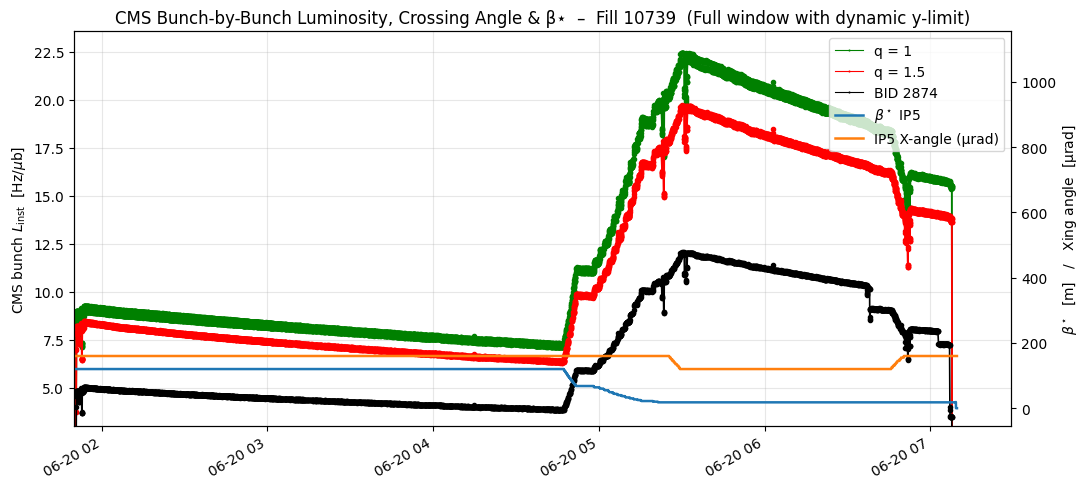

In [ ]:
BUNCH_GROUPS = {
    "q = 1"  : ([20, 500],    "green"),
    "q = 1.5": ([1250, 1800], "red"),
}
SOLO_BID = 2874  # plotted in black
dynamic_ylim = True  # Enable dynamic y-axis scaling
title_suffix = "Full window with dynamic y-limit"

# --- Load CMS bunch-by-bunch data ---
def load_bunch_array(pv_name: str, bid_list):
    raw = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)
    mat    = np.stack(raw[pv_name].values)  # nTimes × 3564
    sliced = mat[:, bid_list]
    return pd.DataFrame(
        sliced,
        index   = raw.index,
        columns = [f"B{bid}" for bid in bid_list]
    )

# --- Bunches to load ---
all_bids = [*BUNCH_GROUPS["q = 1"][0], *BUNCH_GROUPS["q = 1.5"][0], SOLO_BID]
df_cms = load_bunch_array(CMS_PV, all_bids)  # << switched from df_atlas → df_cms

# --- Load machine parameters ---
df_beta = (
    dd.read_parquet(DATADIR, columns=[BETASTAR_PV])
      .dropna()
      .compute()
)
df_beta.index = pd.to_datetime(df_beta.index, unit="ns")
df_beta.sort_index(inplace=True)

df_xing = (
    dd.read_parquet(DATADIR, columns=[XING_PV])
      .dropna()
      .compute()
)
df_xing.index = pd.to_datetime(df_xing.index, unit="ns")
df_xing.sort_index(inplace=True)

# --- Synchronize time range ---
t0 = max(df_cms.index.min(), df_beta.index.min(), df_xing.index.min())
t1 = min(df_cms.index.max(), df_beta.index.max(), df_xing.index.max())
df_cms = df_cms.loc[t0:t1]
df_beta = df_beta.loc[t0:t1]
df_xing = df_xing.loc[t0:t1]

# --- Plotting ---
fig, ax_lumi = plt.subplots(figsize=(11, 5))

# Left axis: CMS bunch-by-bunch luminosity
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cms[[f"B{b}" for b in bids]].plot(
        ax=ax_lumi,
        color=colour,
        linewidth=1.2,
        marker=".",
        legend=False
    )
ax_lumi.plot(
    df_cms.index,
    df_cms[f"B{SOLO_BID}"],
    color="black",
    linewidth=1.2,
    marker=".",
    label="_nolegend_"
)
ax_lumi.set_ylabel(r"CMS bunch $L_{\rm inst}$  [Hz/$\mu$b]")  # << updated label

# Y-limit: dynamic if enabled
if dynamic_ylim:
    y_max = df_cms.max().max()
    ax_lumi.set_ylim(3, y_max * 1.05)
else:
    ax_lumi.set_ylim(3, 9.5)

# Title
ax_lumi.set_title(
    f"CMS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({title_suffix})"
)  # << updated title
ax_lumi.grid(alpha=0.3)

# Right axis: β⋆ and X-angle
ax_r = ax_lumi.twinx()
df_beta[BETASTAR_PV].plot(
    ax=ax_r, color="tab:blue", linewidth=1.8, label=r"$\beta^\star$ IP5"
)  # << updated to IP5 for CMS
df_xing[XING_PV].plot(
    ax=ax_r, color="tab:orange", linewidth=1.8, label=r"IP5 X-angle (µrad)"
)  # << updated to IP5
ax_r.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# Legend
custom_handles = [
    Line2D([0], [0], color="green", marker=".",markersize=1, linestyle="-", linewidth=0.8, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".",markersize=1, linestyle="-", linewidth=0.8, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".",markersize=1, linestyle="-", linewidth=0.8, label="BID 2874"),
    ax_r.lines[0],
    ax_r.lines[1],
]
ax_lumi.legend(handles=custom_handles, loc="upper right")

# Optional x-range zoom
ax_lumi.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


### Split

β⋆ starts changing (after 04:00) at: 2025-06-20 04:47:13.295738525


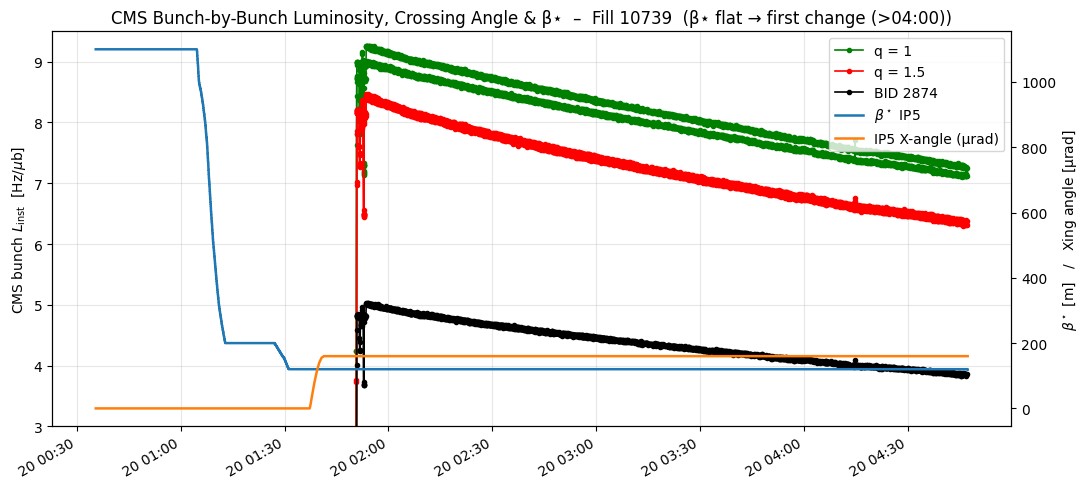

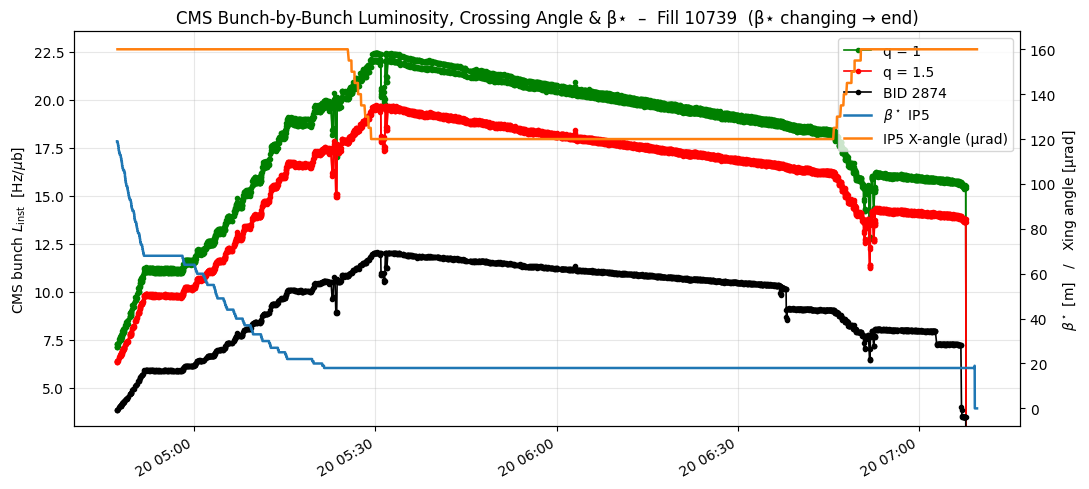

In [ ]:
# --- Detect β⋆ change ---
tol = 1e-4                                   
day0        = df_beta.index[0].floor("D")    
t_threshold = day0 + pd.Timedelta(hours=4) 
beta_series = df_beta[BETASTAR_PV]

baseline = beta_series.loc[:t_threshold].iloc[-1]  # value at or before 04:00
after_4h  = beta_series.loc[t_threshold:]
t_change  = after_4h[(after_4h - baseline).abs() > tol].index[0]

print("β⋆ starts changing (after 04:00) at:", t_change)

# --- Plotting Function ---
def plot_window(t_start, t_stop, title_suffix, dynamic_ylim=False):
    sl_cms  = df_cms.loc[t_start:t_stop]
    sl_beta = df_beta.loc[t_start:t_stop]
    sl_xing = df_xing.loc[t_start:t_stop]

    fig, ax_lumi = plt.subplots(figsize=(11, 5))

    # Left axis – CMS bunches
    for lbl, (bids, colour) in BUNCH_GROUPS.items():
        sl_cms[[f"B{b}" for b in bids]].plot(
            ax=ax_lumi,
            color=colour,
            lw=1.2,
            marker=".",
            legend=False
        )
    ax_lumi.plot(
        sl_cms.index,
        sl_cms[f"B{SOLO_BID}"],
        color="black",
        lw=1.2,
        marker=".",
        label="_nolegend_"
    )

    ax_lumi.set_ylabel(r"CMS bunch $L_{\rm inst}$  [Hz/$\mu$b]")
    if dynamic_ylim:
        y_max = sl_cms.max().max()
        ax_lumi.set_ylim(3, y_max * 1.05)
    else:
        ax_lumi.set_ylim(3, 9.5)

    ax_lumi.set_title(
        f"CMS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({title_suffix})"
    )
    ax_lumi.grid(alpha=0.3)

    # Right axis – β⋆ and crossing angle
    ax_r = ax_lumi.twinx()
    sl_beta[BETASTAR_PV].plot(
        ax=ax_r,
        color="tab:blue",
        lw=1.8,
        label=r"$\beta^\star$ IP5"
    )
    sl_xing[XING_PV].plot(
        ax=ax_r,
        color="tab:orange",
        lw=1.8,
        label=r"IP5 X-angle (µrad)"
    )
    ax_r.set_ylabel(r"$\beta^\star$ [m]   /   Xing angle [µrad]")

    # Combined legend
    handles = [
        Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
        Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
        Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
        ax_r.lines[0],
        ax_r.lines[1],
    ]
    ax_lumi.legend(handles=handles, loc="upper right")
    plt.tight_layout()
    return fig

# --- Draw plots ---
fig_before = plot_window(df_cms.index.min(), t_change,
                         "β⋆ flat → first change (>04:00)")

fig_after  = plot_window(t_change, df_cms.index.max(),
                         "β⋆ changing → end", dynamic_ylim=True)

plt.show()


### first window analysis

#### normalized by maximum

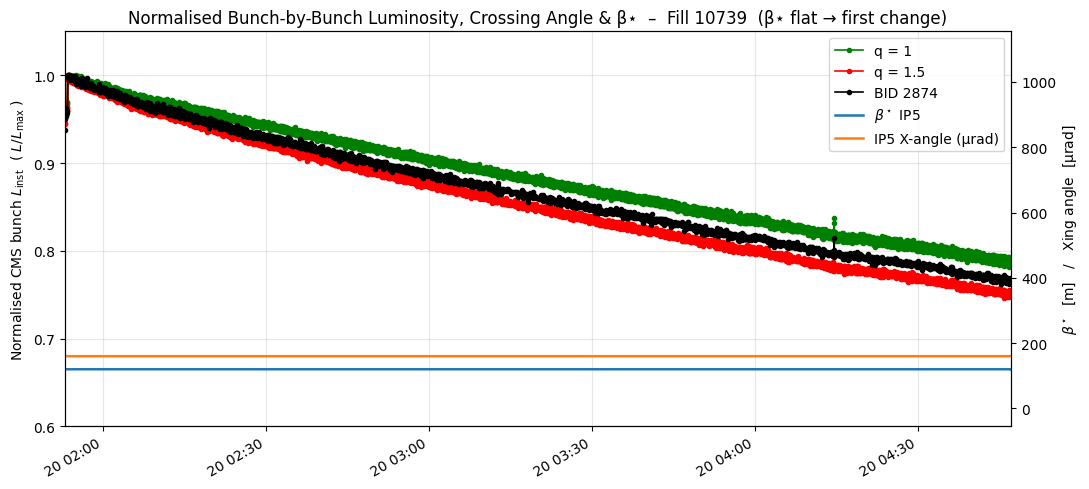

In [ ]:
# 1) slice the data to the “before β⋆-change” period
df_first   = df_cms.loc[df_cms.index.min() : t_change]
beta_first = df_beta.loc[df_beta.index.min() : t_change]
xing_first = df_xing.loc[df_xing.index.min() : t_change]

# 2) per-bunch maxima in that window
max_vals = df_first.max()  # one value per column “B###”

# 3) normalise every bunch curve by its own maximum
df_norm = df_first.div(max_vals)

# 4) plot – same style as original, now for CMS
fig_norm, ax_lum = plt.subplots(figsize=(11, 5))

for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_norm[[f"B{b}" for b in bids]].plot(
        ax=ax_lum,
        color=colour,
        lw=1.2,
        marker=".",
        legend=False
    )

# solo bunch
ax_lum.plot(
    df_norm.index,
    df_norm[f"B{SOLO_BID}"],
    color="black",
    lw=1.2,
    marker=".",
    label="_nolegend_"
)

# Axis labels and title
ax_lum.set_ylabel("Normalised CMS bunch $L_{\\rm inst}$  ( $L/L_{\\max}$ )")
ax_lum.set_ylim(0.6, 1.05)
ax_lum.set_title(
    "Normalised Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  (β⋆ flat → first change)"
)
ax_lum.grid(alpha=0.3)

# Right axis – β⋆ and crossing angle
ax_r = ax_lum.twinx()
beta_first[BETASTAR_PV].plot(
    ax=ax_r,
    color="tab:blue",
    lw=1.8,
    label=r"$\beta^\star$ IP5"
)
xing_first[XING_PV].plot(
    ax=ax_r,
    color="tab:orange",
    lw=1.8,
    label=r"IP5 X-angle (µrad)"
)
ax_r.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# Legend
handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],
    ax_r.lines[1],
]

# X-axis zoom
start_time = df_first.index[0].replace(hour=1, minute=53, second=0)
ax_lum.set_xlim([start_time, t_change])

ax_lum.legend(handles=handles, loc="upper right")
plt.tight_layout()
plt.show()


#### integrated Luminosity

/tmp/ipykernel_41495/2598838936.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm[col].values, t_sec, initial=0.0)


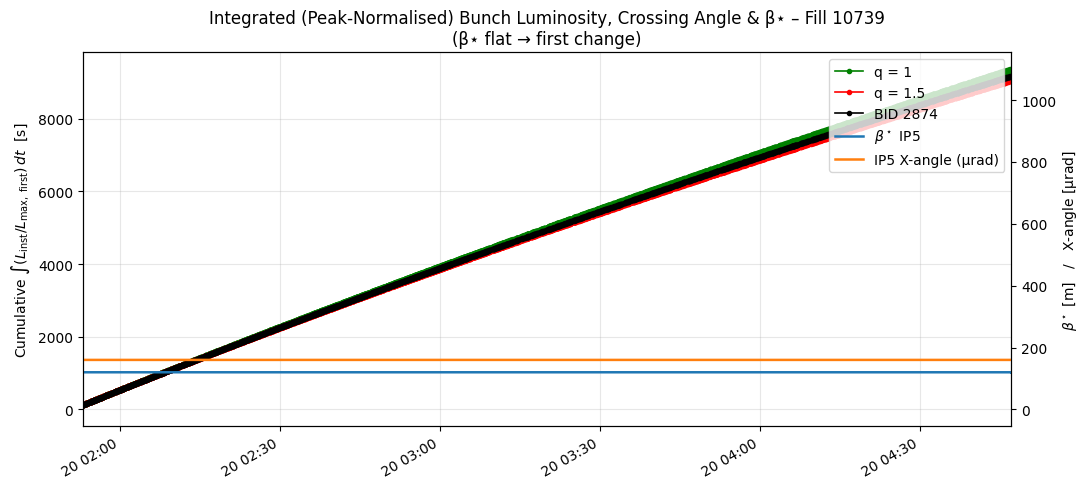

In [ ]:
# A) Slice data before β⋆ changes
df_first   = df_cms.loc[df_cms.index.min() : t_change]
beta_first = df_beta.loc[df_beta.index.min() : t_change]
xing_first = df_xing.loc[df_xing.index.min() : t_change]

# B) Normalise each bunch by its own maximum in that window
max_vals_first = df_first.max()
df_norm = df_first.div(max_vals_first)

# C) Compute cumulative integral (in seconds, dimensionless y)
t_sec = (df_norm.index - df_norm.index[0]).total_seconds()
df_cum_norm = pd.DataFrame(
    {col: cumtrapz(df_norm[col].values, t_sec, initial=0.0)
     for col in df_norm.columns},
    index=df_norm.index
)

# D) Plotting
fig, ax_l = plt.subplots(figsize=(11, 5))

# Left axis – cumulative ∫(L / L_max) dt
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum_norm[[f"B{b}" for b in bids]].plot(
        ax=ax_l, color=colour, lw=1.2, marker=".", legend=False
    )

# Solo bunch 2874
ax_l.plot(
    df_cum_norm.index, df_cum_norm[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_l.set_ylabel(r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]")
ax_l.set_title(
    "Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(β⋆ flat → first change)"
)
ax_l.grid(alpha=0.3)

# Right axis – β⋆ and crossing angle
ax_r = ax_l.twinx()
beta_first[BETASTAR_PV].plot(ax=ax_r, color="tab:blue",   lw=1.8, label=r"$\beta^\star$ IP5")
xing_first[XING_PV]    .plot(ax=ax_r, color="tab:orange", lw=1.8, label=r"IP5 X-angle (µrad)")
ax_r.set_ylabel(r"$\beta^\star$ [m]   /   X-angle [µrad]")

# Combined legend
handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],
    ax_r.lines[1],
]
ax_l.legend(handles=handles, loc="upper right")

# Optional x-axis zoom (same as other plots)
start_time = df_first.index[0].replace(hour=1, minute=53, second=0)
ax_l.set_xlim([start_time, t_change])

plt.tight_layout()
plt.show()


#### statistics

In [ ]:
# Final values (at β⋆ change)
final_values_norm = df_cum_norm.iloc[-1]

print("CMS: Peak-normalised cumulative luminosity delivered up to β⋆ change:\n")
print(final_values_norm.to_string(float_format="%.3e"))

# --- Percentage difference helpers ---
def rel_pct_diff(a, b):
    """Relative percentage difference w.r.t. the first value (a)."""
    return abs(a - b) / abs(a) * 100

def sym_pct_diff(a, b):
    """Symmetric percentage difference (reference-free)."""
    return abs(a - b) / ((abs(a) + abs(b)) / 2) * 100

# --- Bunch comparisons ---
final_vals_norm = df_cum_norm.iloc[-1]  # [s]

# q = 1
L20,  L500  = final_vals_norm["B20"], final_vals_norm["B500"]
rel_20_500 = rel_pct_diff(L20, L500)
sym_20_500 = sym_pct_diff(L20, L500)

# q = 1.5
L1250, L1800 = final_vals_norm["B1250"], final_vals_norm["B1800"]
rel_1250_1800 = rel_pct_diff(L1250, L1800)
sym_1250_1800 = sym_pct_diff(L1250, L1800)

print("\nCMS: Peak-normalised cumulative luminosity up to β⋆ change (seconds):\n")

print(f"  B20   : {L20 : .3e} s")
print(f"  B500  : {L500: .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500 :6.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500 :6.4f} %\n")

print(f"  B1250 : {L1250: .3e} s")
print(f"  B1800 : {L1800: .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800 :6.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800 :6.4f} %")

# --- Total (sum-based) comparison ---
group_q1  = ["B20", "B500"]
group_q15 = ["B1250", "B1800"]

tot_q1  = final_vals_norm[group_q1].sum()
tot_q15 = final_vals_norm[group_q15].sum()

sym_pct = sym_pct_diff(tot_q1, tot_q15)
rel_pct = rel_pct_diff(tot_q1, tot_q15)

print("\nCMS: Group SUM of peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 total (B20 + B500):       {tot_q1 : .3e} s")
print(f"  q = 1.5 total (B1250 + B1800):  {tot_q15: .3e} s")
print(f"  Symmetric % difference:         {sym_pct:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_pct:.3f} %")

# --- Mean-based comparison ---
tot_q1_mean  = final_vals_norm[group_q1].mean()
tot_q15_mean = final_vals_norm[group_q15].mean()

sym_pct_mean = sym_pct_diff(tot_q1_mean, tot_q15_mean)
rel_pct_mean = rel_pct_diff(tot_q1_mean, tot_q15_mean)

print("\nCMS: Group MEAN of peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 mean (B20 + B500):        {tot_q1_mean : .3e} s")
print(f"  q = 1.5 mean (B1250 + B1800):   {tot_q15_mean: .3e} s")
print(f"  Symmetric % difference:         {sym_pct_mean:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_pct_mean:.3f} %")


CMS: Peak-normalised cumulative luminosity delivered up to β⋆ change:

B20     9.369e+03
B500    9.338e+03
B1250   9.073e+03
B1800   9.049e+03
B2874   9.177e+03

CMS: Peak-normalised cumulative luminosity up to β⋆ change (seconds):

  B20   :  9.369e+03 s
  B500  :  9.338e+03 s
    →  relative % diff (ref B20):   0.3321 %
    →  symmetric % diff:            0.3326 %

  B1250 :  9.073e+03 s
  B1800 :  9.049e+03 s
    →  relative % diff (ref B1250): 0.2637 %
    →  symmetric % diff:            0.2641 %

CMS: Group SUM of peak-normalised cumulative luminosity at β⋆ change:
  q = 1 total (B20 + B500):        1.871e+04 s
  q = 1.5 total (B1250 + B1800):   1.812e+04 s
  Symmetric % difference:         3.170 %
  Relative  % difference (ref q=1): 3.121 %

CMS: Group MEAN of peak-normalised cumulative luminosity at β⋆ change:
  q = 1 mean (B20 + B500):         9.353e+03 s
  q = 1.5 mean (B1250 + B1800):    9.061e+03 s
  Symmetric % difference:         3.170 %
  Relative  % difference (ref q=1):

### overall

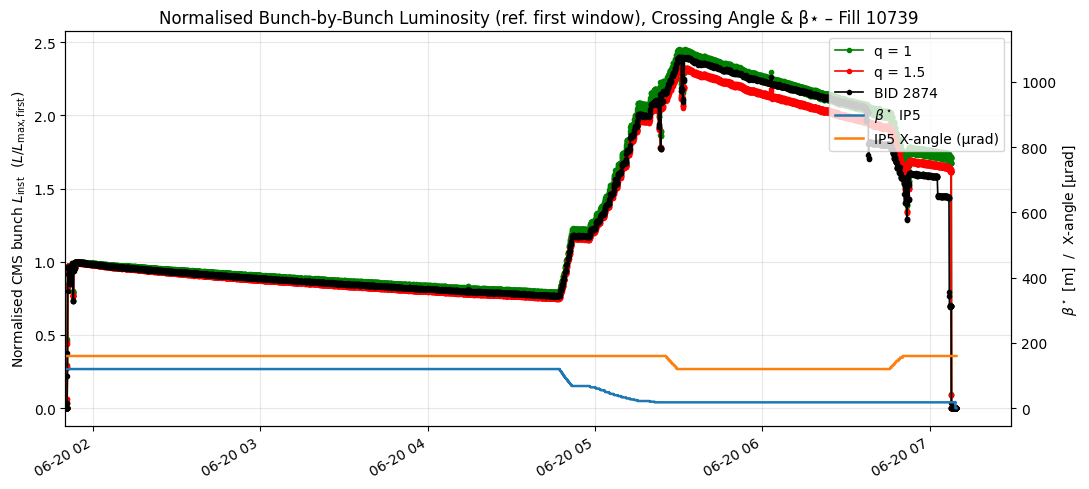

In [ ]:
# ────────────────────────────────────────────────────────────────────
# Normalise the *entire CMS fill* to the first-window peak of each bunch
# ────────────────────────────────────────────────────────────────────

# 1) reference maxima from the first split (β⋆ flat → t_change)
max_first = df_cms.loc[t0:t_change].max()

# 2) normalise the *entire* df_cms by those maxima
df_norm_all = df_cms.div(max_first)

# 3) plot – same layout as original
pad  = 0.05  # 5% head- & foot-room
ymin = df_norm_all.min().min()
ymax = df_norm_all.max().max()
yrange = ymax - ymin
ylow  = ymin - pad * yrange
yhigh = ymax + pad * yrange

fig, ax_l = plt.subplots(figsize=(11, 5))

# Left axis – normalised bunch curves
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_norm_all[[f"B{b}" for b in bids]].plot(
        ax=ax_l, color=colour, lw=1.2, marker=".", legend=False
    )

# Solo bunch
ax_l.plot(
    df_norm_all.index, df_norm_all[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_l.set_ylabel(
    r"Normalised CMS bunch $L_{\rm inst}$  ($L/L_{\max,\mathrm{first}}$)"
)
ax_l.set_ylim(ylow, yhigh)
ax_l.set_title(
    "Normalised Bunch-by-Bunch Luminosity (ref. first window), "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l.grid(alpha=0.3)

# Right axis – β⋆ and crossing angle (CMS: IP5)
ax_r = ax_l.twinx()
df_beta[BETASTAR_PV].plot(ax=ax_r, color="tab:blue",   lw=1.8, label=r"$\beta^\star$ IP5")
df_xing[XING_PV]   .plot(ax=ax_r, color="tab:orange", lw=1.8, label=r"IP5 X-angle (µrad)")
ax_r.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

# Combined legend
handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],
    ax_r.lines[1],
]
ax_l.legend(handles=handles, loc="upper right")

# Optional x-range zoom
ax_l.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


/tmp/ipykernel_41495/266903205.py:4: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm_all[col].values, t_sec_all, initial=0.0)


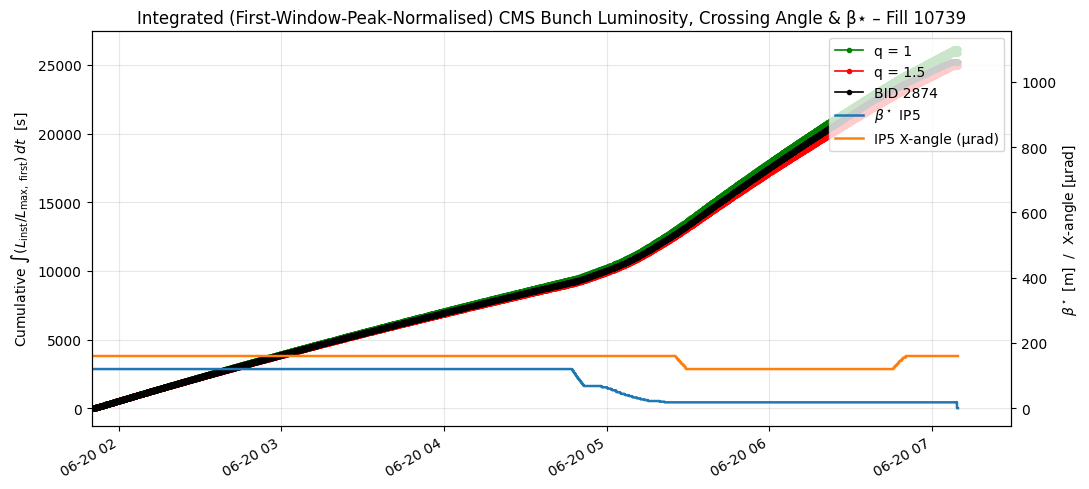

In [ ]:
# 1) cumulative integral for each bunch
t_sec_all = (df_norm_all.index - df_norm_all.index[0]).total_seconds()
df_cum_all = pd.DataFrame(
    {col: cumtrapz(df_norm_all[col].values, t_sec_all, initial=0.0)
     for col in df_norm_all.columns},
    index=df_norm_all.index
)

# 2) dynamic y-range with 5% padding
pad = 0.05
ymin, ymax = df_cum_all.min().min(), df_cum_all.max().max()
yrange     = ymax - ymin
ylow, yhigh = ymin - pad * yrange, ymax + pad * yrange

# 3) plot
fig_int, ax_l = plt.subplots(figsize=(11, 5))

# left axis – cumulative ∫(L / L_max,first) dt
for lbl, (bids, colour) in BUNCH_GROUPS.items():
    df_cum_all[[f"B{b}" for b in bids]].plot(
        ax=ax_l, color=colour, lw=1.2, marker=".", legend=False
    )

# solo bunch
ax_l.plot(
    df_cum_all.index, df_cum_all[f"B{SOLO_BID}"],
    color="black", lw=1.2, marker=".", label="_nolegend_"
)

ax_l.set_ylabel(r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]")
ax_l.set_ylim(ylow, yhigh)
ax_l.set_title(
    "Integrated (First-Window-Peak-Normalised) CMS Bunch Luminosity, "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l.grid(alpha=0.3)

# right axis – β⋆ and X-angle (CMS: IP5)
ax_r = ax_l.twinx()
df_beta[BETASTAR_PV].plot(ax=ax_r, color="tab:blue",   lw=1.8, label=r"$\beta^\star$ IP5")
df_xing[XING_PV]   .plot(ax=ax_r, color="tab:orange", lw=1.8, label=r"IP5 X-angle (µrad)")
ax_r.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

# legend
handles = [
    Line2D([0], [0], color="green", marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",   marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black", marker=".", lw=1.2, label=f"BID {SOLO_BID}"),
    ax_r.lines[0],
    ax_r.lines[1],
]
ax_l.legend(handles=handles, loc="upper right")

# x-range zoom
ax_l.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()

In [ ]:
# ─────────────────────────────────────────────────────────────────────
# CMS: Peak-normalised cumulative luminosity over the entire fill
# ─────────────────────────────────────────────────────────────────────

final_values_norm_all = df_cum_all.iloc[-1]  # units: seconds

print("CMS: Peak-normalised cumulative luminosity delivered over the whole fill:\n")
print(final_values_norm_all.to_string(float_format="%.3e"))

# --- Difference helpers ---
def rel_pct_diff_all(a, b):
    return abs(a - b) / abs(a) * 100

def sym_pct_diff_all(a, b):
    return abs(a - b) / ((abs(a) + abs(b)) / 2) * 100

# --- Individual bunches ---
final_vals_norm_all = df_cum_all.iloc[-1]

# q = 1
L20_all, L500_all = final_vals_norm_all["B20"], final_vals_norm_all["B500"]
rel_20_500_all = rel_pct_diff_all(L20_all, L500_all)
sym_20_500_all = sym_pct_diff_all(L20_all, L500_all)

# q = 1.5
L1250_all, L1800_all = final_vals_norm_all["B1250"], final_vals_norm_all["B1800"]
rel_1250_1800_all = rel_pct_diff_all(L1250_all, L1800_all)
sym_1250_1800_all = sym_pct_diff_all(L1250_all, L1800_all)

print("\nCMS: Peak-normalised cumulative luminosity over the whole fill (seconds):\n")
print(f"  B20   : {L20_all   : .3e} s")
print(f"  B500  : {L500_all  : .3e} s")
print(f"    →  relative % diff (ref B20):   {rel_20_500_all :8.4f} %")
print(f"    →  symmetric % diff:            {sym_20_500_all :8.4f} %\n")

print(f"  B1250 : {L1250_all : .3e} s")
print(f"  B1800 : {L1800_all : .3e} s")
print(f"    →  relative % diff (ref B1250): {rel_1250_1800_all :8.4f} %")
print(f"    →  symmetric % diff:            {sym_1250_1800_all :8.4f} %")

# --- Mean of each group ---
mean_q1_all  = final_vals_norm_all[["B20", "B500"]].mean()
mean_q15_all = final_vals_norm_all[["B1250", "B1800"]].mean()

rel_mean_all = rel_pct_diff_all(mean_q1_all,  mean_q15_all)
sym_mean_all = sym_pct_diff_all(mean_q1_all,  mean_q15_all)

print("\nCMS: Mean peak-normalised cumulative luminosity over the whole fill:\n")
print(f"  q = 1   mean (B20 & B500)   : {mean_q1_all  : .3e} s")
print(f"  q = 1.5 mean (B1250 & B1800): {mean_q15_all : .3e} s")
print(f"\n  Relative  % diff (ref q = 1 mean): {rel_mean_all:8.4f} %")
print(f"  Symmetric % diff:                  {sym_mean_all:8.4f} %")

# --- Total of each group ---
group_q1_all   = ["B20", "B500"]
group_q15_all  = ["B1250", "B1800"]

tot_q1_all  = final_vals_norm_all[group_q1_all].sum()
tot_q15_all = final_vals_norm_all[group_q15_all].sum()

rel_tot_all = rel_pct_diff_all(tot_q1_all,  tot_q15_all)
sym_tot_all = sym_pct_diff_all(tot_q1_all, tot_q15_all)

print("\nCMS: Total peak-normalised cumulative luminosity over the whole fill:\n")
print(f"  q = 1   total (B20 + B500)   : {tot_q1_all  : .3e} s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15_all : .3e} s")
print(f"\n  Relative  % diff (ref q = 1 total): {rel_tot_all:8.4f} %")
print(f"  Symmetric % diff:                    {sym_tot_all:8.4f} %")


CMS: Peak-normalised cumulative luminosity delivered over the whole fill:

B20     2.614e+04
B500    2.588e+04
B1250   2.499e+04
B1800   2.490e+04
B2874   2.524e+04

CMS: Peak-normalised cumulative luminosity over the whole fill (seconds):

  B20   :  2.614e+04 s
  B500  :  2.588e+04 s
    →  relative % diff (ref B20):     1.0045 %
    →  symmetric % diff:              1.0096 %

  B1250 :  2.499e+04 s
  B1800 :  2.490e+04 s
    →  relative % diff (ref B1250):   0.3858 %
    →  symmetric % diff:              0.3865 %

CMS: Mean peak-normalised cumulative luminosity over the whole fill:

  q = 1   mean (B20 & B500)   :  2.601e+04 s
  q = 1.5 mean (B1250 & B1800):  2.494e+04 s

  Relative  % diff (ref q = 1 mean):   4.0928 %
  Symmetric % diff:                    4.1783 %

CMS: Total peak-normalised cumulative luminosity over the whole fill:

  q = 1   total (B20 + B500)   :  5.202e+04 s
  q = 1.5 total (B1250 + B1800):  4.989e+04 s

  Relative  % diff (ref q = 1 total):   4.0928 %
  Symm